In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

from ml_genn import InputLayer, Layer, SequentialNetwork
from ml_genn.callbacks import Checkpoint, SpikeRecorder, VarRecorder, Callback
from ml_genn.compilers import EventPropCompiler, InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.initializers import Normal
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput, LeakyIntegrateFireInput
from ml_genn.optimisers import Adam
from ml_genn.serialisers import Numpy
from ml_genn.synapses import Exponential
from time import perf_counter

from ml_genn.utils.data import (calc_latest_spike_time, linear_latency_encode_data)

from ml_genn.compilers.event_prop_compiler import default_params

import random
import librosa

In [3]:
NUM_INPUT = 40
NUM_HIDDEN = 256
NUM_OUTPUT = 20

NUM_EPOCH = 50

BATCH_SIZE = 128

INPUT_FRAME_TIMESTEP = 2

INPUT_SCALE = 0.01

In [4]:
# Load testing data
x_train = np.load("/its/home/ts468/data/rawHD/experimental_1/training_x_data.npy")
y_train = np.load("/its/home/ts468/data/rawHD/experimental_1/training_y_data.npy")

x_test = np.load("/its/home/ts468/data/rawHD/experimental_1/testing_x_data.npy")
y_test = np.load("/its/home/ts468/data/rawHD/experimental_1/testing_y_data.npy")

training_details = pd.read_csv("/its/home/ts468/data/rawHD/experimental_1/training_details.csv")
testing_details = pd.read_csv("/its/home/ts468/data/rawHD/experimental_1/testing_details.csv")

training_images = np.swapaxes(x_train, 1, 2) 
testing_images = np.swapaxes(x_test, 1, 2) 

training_images = training_images + abs(np.floor(training_images.min()))
testing_images = testing_images + abs(np.floor(testing_images.min()))

training_labels = y_train
testing_labels = y_test

In [5]:
print(testing_details.head())
speaker_id = np.sort(testing_details.Speaker.unique())
print(np.sort(testing_details.Speaker.unique()))

   Unnamed: 0 Language  Speaker  Trial  Label  classification label
0           0  english        4     13      9                     9
1           1   german        7      8      7                    17
2           2   german        4     12      6                    16
3           3  english        5     30      4                     4
4           4  english       10     40      4                     4
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [6]:
speaker_id

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [7]:
class CSVTrainLog(Callback):
    def __init__(self, filename, output_pop, resume):
        # Create CSV writer
        self.file = open(filename, "a" if resume else "w")
        self.csv_writer = csv.writer(self.file, delimiter=",")

        # Write header row if we're not resuming from an existing training run
        if not resume:
            self.csv_writer.writerow(["Epoch", "Num trials", "Number correct", "accuracy", "Time"])

        self.output_pop = output_pop

    def on_epoch_begin(self, epoch):
        self.start_time = perf_counter()

    def on_epoch_end(self, epoch, metrics):
        m = metrics[self.output_pop]
        self.csv_writer.writerow([epoch, m.total, m.correct, m.correct / m.total,
                                  perf_counter() - self.start_time])
        self.file.flush()

In [8]:
# Create sequential model
serialiser = Numpy("latency_mnist_checkpoints")
network = SequentialNetwork(default_params)
with network:
    # Populations
    input = InputLayer(LeakyIntegrateFireInput(v_thresh=5,
                                               tau_mem=2, 
                                               input_frames=80, 
                                               input_frame_timesteps=INPUT_FRAME_TIMESTEP),
                        NUM_INPUT, 
                        record_spikes = True)
    
    hidden = Layer(Dense(Normal(mean=0.078, 
                                sd=0.045)), 
                   LeakyIntegrateFire(v_thresh=1.0, 
                                      tau_mem=1.0,
                                      tau_refrac=None),
                   NUM_HIDDEN, 
                   Exponential(2.0), #5
                   record_spikes=True)
    
    output = Layer(Dense(Normal(mean=0.2, 
                                sd=0.37)),
                   LeakyIntegrate(tau_mem=1.0, 
                                  readout="avg_var"),
                   NUM_OUTPUT, 
                   Exponential(2.0), #5
                   record_spikes=True)

## Compilation


In [9]:
compiler = EventPropCompiler(example_timesteps=80 * INPUT_FRAME_TIMESTEP,
                         losses="sparse_categorical_crossentropy",
                         optimiser=Adam(1e-3), batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)

In [10]:
# "speaker should be a numpy array of the speaker ids of each recording in the training set "
speaker = list(testing_details.loc[:, "Speaker"])

In [11]:
training_images[0].shape

(80, 40)

In [12]:
for speaker_left in speaker_id:
    print(speaker_left)
    train= np.where(speaker != speaker_left)[0]
    evalu= np.where(speaker == speaker_left)[0]
    train_spikes= [ training_images[i] for i in train ]
    eval_spikes= [ training_images[i] for i in evalu ]
    train_labels= [ training_labels[i] for i in train ]
    eval_labels= [ training_labels[i] for i in evalu ]
    break

print(len(training_images))
print(len(train_spikes))

0
8156
2217


## Training


In [13]:
for speaker_left in speaker_id:
    train= np.where(speaker != speaker_left)[0]
    evalu= np.where(speaker == speaker_left)[0]
    train_spikes= np.array([ training_images[i] for i in train ])
    eval_spikes= np.array([ training_images[i] for i in evalu ])
    train_labels= [ training_labels[i] for i in train ]
    eval_labels= [ training_labels[i] for i in evalu ]
    
    #print(train_spikes)
    #print(eval_spikes)
    #print(train_labels)
    #print(eval_labels)    

    with compiled_net:
        # Evaluate model on numpy dataset
        start_time = perf_counter()
        start_epoch = 0
        callbacks = ["batch_progress_bar", 
                    Checkpoint(serialiser), 
                    CSVTrainLog("train_output.csv", 
                                output,
                                False)]
        metrics  = compiled_net.train({input: train_spikes * INPUT_SCALE},
                                        {output: train_labels},
                                        num_epochs=NUM_EPOCH, 
                                        shuffle=True,
                                        callbacks=callbacks,
                                        validation_x= {input: eval_spikes * INPUT_SCALE},
                                        validation_y= {output: eval_labels})

./EventPropCompiler_CODE/synapseUpdateCUDAOptim.cc(59): warning #177-D: variable "shLg" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(190): warning #177-D: variable "lYTrue" was declared but never referenced

./EventPropCompiler_CODE/customUpdateCUDAOptim.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced

./EventPropCompiler_CODE/synapseUpdateCUDAOptim.cc(59): warning #177-D: variable "shLg" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(190): warning #177-D: variable "lYTrue" was declared but never referenced

./EventPropCompiler_CODE/customUpdateCUDAOptim.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced



swig/python detected a memory leak of type 'CodeGenerator::CUDA::Backend *', no destructor found.
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/rSNN trained in GeNN with EventProp/EventPropCompiler_CODE'


synapseUpdate.cc(59): warning #177-D: variable "shLg" was declared but never referenced

neuronUpdate.cc(190): warning #177-D: variable "lYTrue" was declared but never referenced

customUpdate.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced



make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/rSNN trained in GeNN with EventProp/EventPropCompiler_CODE'


/its/home/ts468/PhD/pythonenv/genn_4_8_1/ve/genn_4_8_1/lib/python3.8/site-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s, SparseCategoricalAccuracy: 0.7500]


## Evaluate
Load weights checkpointed from last epoch:

In [14]:
network.load((14,), serialiser)

Create an ``InferenceCompiler`` and compile network for inference:

In [15]:
compiler = InferenceCompiler(evaluate_timesteps=80 * INPUT_FRAME_TIMESTEP,
                             reset_in_syn_between_batches=True,
                             batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)

In [16]:
with compiled_net:
    callbacks = ["batch_progress_bar", 
                 SpikeRecorder(input, key="input_spikes"), 
                 SpikeRecorder(hidden, key="hidden_spikes"),
                 SpikeRecorder(output, key="output_spikes"),
                 VarRecorder(output, "v", key="v_output")]
    metrics, cb_data = compiled_net.evaluate({input: testing_images * INPUT_SCALE},
                                             {output: testing_labels},
                                             callbacks=callbacks)

./InferenceCompiler_CODE/synapseUpdateCUDAOptim.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced

./InferenceCompiler_CODE/synapseUpdateCUDAOptim.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced



swig/python detected a memory leak of type 'CodeGenerator::CUDA::Backend *', no destructor found.
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/rSNN trained in GeNN with EventProp/InferenceCompiler_CODE'


synapseUpdate.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced



make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/rSNN trained in GeNN with EventProp/InferenceCompiler_CODE'


100%|██████████| 18/18 [00:00<00:00, 30.19it/s, SparseCategoricalAccuracy: 0.2354]


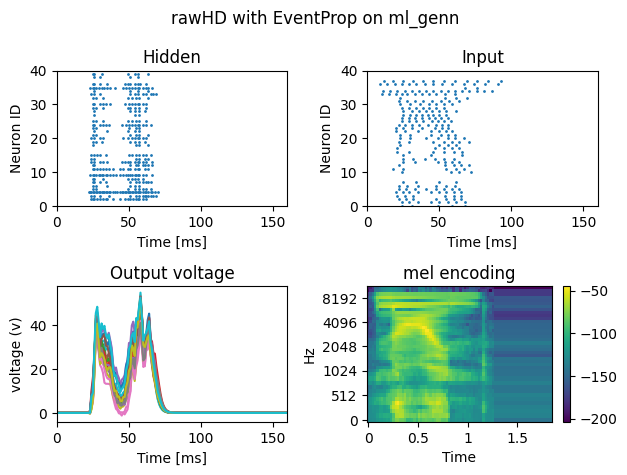

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('rawHD with EventProp on ml_genn')

value = random.randint(0, len(x_test))

ax1.scatter(cb_data["hidden_spikes"][0][value], 
            cb_data["hidden_spikes"][1][value], s=1)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Neuron ID")
ax1.set_title("Hidden")
ax1.set_xlim(0, 80 * INPUT_FRAME_TIMESTEP)
ax1.set_ylim(0, 40)

ax2.scatter(cb_data["input_spikes"][0][value], 
            cb_data["input_spikes"][1][value], s=1)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Neuron ID")
ax2.set_title("Input")
ax2.set_xlim(0, 80 * INPUT_FRAME_TIMESTEP)
ax2.set_ylim(0, 40)

ax3.plot(cb_data["v_output"][value])
ax3.set_xlabel("Time [ms]")
ax3.set_ylabel("voltage (v)")
ax3.set_title("Output voltage")
ax3.set_xlim(0, 80 * INPUT_FRAME_TIMESTEP)
#ax3.set_ylim(0, 40)

sr = 22050
img = librosa.display.specshow(x_test[value], 
                         x_axis='time', 
                         y_axis='mel', 
                         sr=sr, 
                         cmap='viridis')
fig.colorbar(img, ax = ax4)
ax4.set_title("mel encoding")

fig.tight_layout()

plt.show()

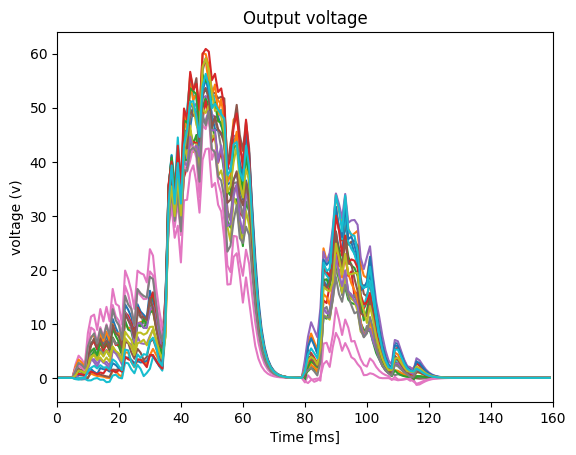

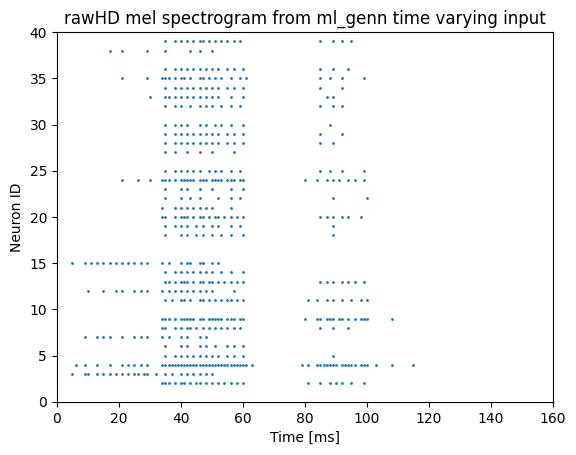

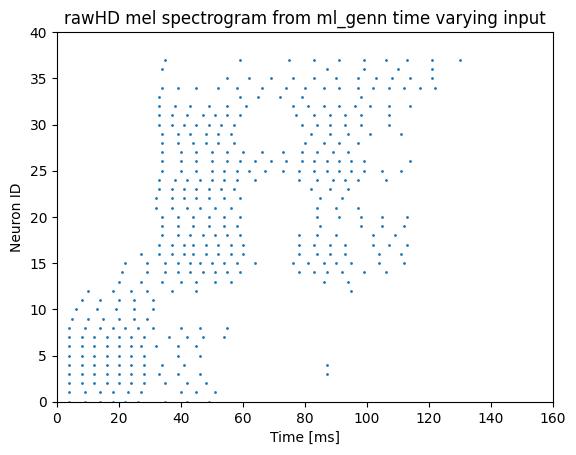

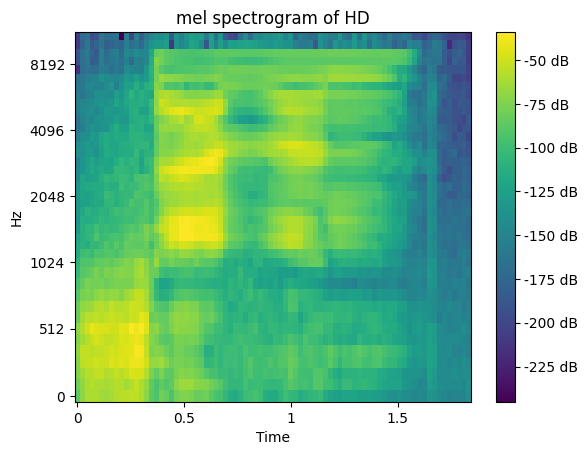

In [18]:
value = random.randint(0, len(x_test))
fig, axis = plt.subplots()

axis.plot(cb_data["v_output"][value])
axis.set_xlabel("Time [ms]")
axis.set_ylabel("voltage (v)")
axis.set_title("Output voltage")
axis.set_xlim(0, 80 * INPUT_FRAME_TIMESTEP)
plt.show()

fig, axis = plt.subplots()
axis.scatter(cb_data["hidden_spikes"][0][value], 
             cb_data["hidden_spikes"][1][value], s=1)
axis.set_xlabel("Time [ms]")
axis.set_ylabel("Neuron ID")
axis.set_title("rawHD mel spectrogram from ml_genn time varying input")
axis.set_xlim(0, 80 * INPUT_FRAME_TIMESTEP)
axis.set_ylim(0, 40)
plt.show()

fig, axis = plt.subplots()
axis.scatter(cb_data["input_spikes"][0][value], 
             cb_data["input_spikes"][1][value], s=1)
axis.set_xlabel("Time [ms]")
axis.set_ylabel("Neuron ID")
axis.set_title("rawHD mel spectrogram from ml_genn time varying input")
axis.set_xlim(0, 80 * INPUT_FRAME_TIMESTEP)
axis.set_ylim(0, 40)
plt.show()

x_train = np.load("/its/home/ts468/data/rawHD/experimental_1/rawHD_x_train.npy")
sr = 22050
librosa.display.specshow(x_test[value], 
                         x_axis='time', 
                         y_axis='mel', 
                         sr=sr, 
                         cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("mel spectrogram of HD")
plt.show()